#Importing impotant pakages

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size =64

train_dataset = datasets.MNIST(root='./MNIST/',train=True,download=True,
                               transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26196030.06it/s]                            


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 441837.81it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143436.91it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7075642.10it/s]                           
8192it [00:00, 181860.10it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
train = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)                    ## dividing in batchs of 64 each

In [0]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  plt.axis('off')
  plt.show()

In [6]:
dataiter = iter(train) #printing shape of a batch (Batch size=64 ) ie 60000/64 such batches
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


## Definining Network Architecture

In [0]:
#Encoder
class Encoder_net(nn.Module):  
    def __init__(self):
        super(Encoder_net, self).__init__()
        self.lin1 = nn.Linear(784, 400)
        self.lin2 = nn.Linear(400, 100)
        self.lin3 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        return torch.tanh(x)

# Decoder
class Decoder_net(nn.Module):  
    def __init__(self):
        super(Decoder_net, self).__init__()
        self.lin1 = nn.Linear(2, 100)
        self.lin2 = nn.Linear(100, 400)
        self.lin3 = nn.Linear(400, 784)
    def forward(self, x):
        x = F.leaky_relu(self.lin1(x), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = F.leaky_relu(self.lin3(x), 0.2)
        
        return torch.tanh(x)

 # Discriminator
class Discriminant(nn.Module):  
    def __init__(self):
        super(Discriminant, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 2)  ## output if (1*2)  assuming  first neuron is giving out P(Y=1|X=x)  and Second P(Y=0 | X=x) 
                                      ## Y=1 ==> True image   Y=0 ==> Fake images      
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(self.lin3(x))
        return F.softmax(x,dim=1)  

In [0]:
encoder = Encoder_net()
decoder = Decoder_net()
discriminant = Discriminant()

In [9]:
encoder

Encoder_net(
  (lin1): Linear(in_features=784, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers ADAM
optim_dec = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=gen_lr)

#regularizing optimizers ADAM
optim_enc_gen = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_disc = torch.optim.Adam(discriminant.parameters(), lr=reg_lr)

## Function for Sampling Data from Bivarient Random Distribution 


In [0]:
## parameters  mean=[0,0] covariance matrix =[[1,0],[0,1]] 
def generate_(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean=[0,0],cov =[[1,0],[0,1]],size=batch_size)).type(torch.float)

torch.Size([64, 1, 28, 28])
torch.Size([64])


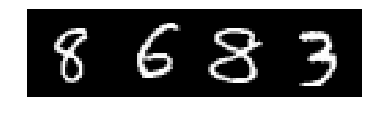

In [12]:
dataiter = iter(train)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4],nrow=4))

In [0]:
## Loss function BCE For training discrimnator in regularization Phase
## MSE for training encoder and decoder in reconstruction Phase
loss= nn.BCELoss()
loss1 = nn.MSELoss()
loss2 = nn.BCELoss()

In [0]:
recon_loss=[]
discr_loss=[]
genra_loss=[]
epochs=30

In [15]:
for epoch in range(epochs):
  dl=0
  rl=0
  gl=0
  print(" Epoch No  {} ".format(epoch))
  for i,(images,target) in enumerate(train):
    
    batch_size=images.size(0)
    images=images.view(batch_size,-1) ## 64*28*28 ===>> 64*784
    images=Variable(images,requires_grad=False)
    
    ## Getting True And Fake Lables Ready
    ###################################################
    
    ## True Data ==>  one coming out of encoder 
    
    true_labels=np.zeros(shape=(batch_size,2))
    true_labels[:0]=1.0   ## As defined in network architecture 1st neuron if for true images 
    true_labels = torch.from_numpy(true_labels).type(torch.FloatTensor)
    true_labels = Variable(true_labels,requires_grad=False)
    
    ## Fake Data  ==> data samples from bivarient Gaussian  distribution
    
    fake_labels=np.zeros(shape=(batch_size,2))
    fake_labels[:1]=1.0
    fake_labels = torch.from_numpy(fake_labels).type(torch.FloatTensor)
    fake_labels = Variable(fake_labels,requires_grad=False)
    
    #####################################################
    ## resetting  grads to zero
    optim_dec.zero_grad()
    optim_enc.zero_grad()
    optim_disc.zero_grad()
    optim_enc_gen.zero_grad()
    
    ##############################
    
    ## Reconstruction Phase 
    enc_out=encoder(images)
    dec_out=decoder(enc_out)
    reco=loss1(images,dec_out)
    reco.backward()
    optim_dec.step()
    optim_enc.step()
    
    #######################
    
    ## Regularization Phase
    
    fake_data = Variable(generate_(batch_size))
    fake_pred = discriminant(fake_data)
    true_data = encoder(images)
    true_pred = discriminant(true_data)
    
    dis_loss=loss(fake_pred,fake_labels)+loss(true_pred,true_labels) 
    
    dis_loss.backward(retain_graph=True)
    optim_disc.step()
    
    discriminant.eval() ## No Further training of discriminator 
 
    encl=loss(fake_pred,true_labels)+loss(true_pred,fake_labels)  ## Since we are not updating dicriminator the encoder will want to resemble its distribution with the
                                                                  ## Bivarient Gaussian ==> Fooling the Discriminator
    encl.backward(retain_graph=True)
    optim_enc_gen.step()
    
    dl=dl+dis_loss.item()
    rl=rl+reco.item()
    gl=gl+encl.item()
    if(i%150==0):
        print(" Iteration No : {}  Reconsturction loss : {}   Discrimant loss : {}".format(i,reco.item(),dis_loss.item()))
   
  print("Epoch : {} Complete".format(epoch))
  
    

 Epoch No  0 
 Iteration No : 0  Reconsturction loss : 0.0999881699681282   Discrimant loss : 1.395721435546875
 Iteration No : 150  Reconsturction loss : 0.06468655169010162   Discrimant loss : 1.3887125253677368
 Iteration No : 300  Reconsturction loss : 0.05771901085972786   Discrimant loss : 1.388129711151123
 Iteration No : 450  Reconsturction loss : 0.050431057810783386   Discrimant loss : 1.3871315717697144
 Iteration No : 600  Reconsturction loss : 0.053863171488046646   Discrimant loss : 1.3866167068481445
 Iteration No : 750  Reconsturction loss : 0.053312331438064575   Discrimant loss : 1.3864994049072266
 Iteration No : 900  Reconsturction loss : 0.05089598149061203   Discrimant loss : 1.38643479347229
Epoch : 0 Complete
 Epoch No  1 
 Iteration No : 0  Reconsturction loss : 0.05468571558594704   Discrimant loss : 1.386398196220398
 Iteration No : 150  Reconsturction loss : 0.04868084192276001   Discrimant loss : 1.3863601684570312
 Iteration No : 300  Reconsturction loss :

##Genrating  Digits from Normal Distribution

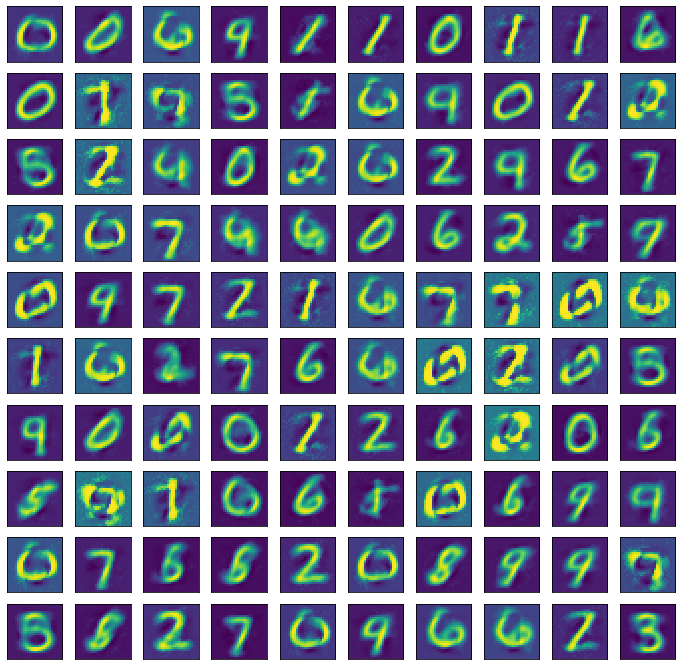

In [16]:
decoder.eval()
z = generate_(100)
generated_images = Variable(decoder(z),requires_grad =False)
z= generated_images.reshape((100,28,28))
z=z.cpu().detach().numpy()
fig=plt.figure(figsize=(12, 12))

columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = z[i-1]
    fig.add_subplot(rows, columns,i)
    
    show = plt.imshow(img)
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.savefig('result.jpg')
plt.show()